In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys 
import os

# TODO: make more pythonic
# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(sys.path[0])))))
print(os.getcwd())
print(sys.path[0])


%matplotlib inline
%load_ext autoreload
%autoreload 2

/accounts/grad/wtorous/rule-vetting
/accounts/grad/wtorous/rule-vetting/rulevetting/projects/csi_pecarn/notebooks
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#from sklearn.preprocessing import StandardScaler
import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset

In [3]:
eda_df = Dataset().get_data()

kwargs {'clean_data': {'use_kappa': False, 'use_robust_av': True}, 'preprocess_data': {'frac_missing_allowed': 0.05}, 'extract_features': {'drop_negative_columns': False}}


In [4]:
outcome_def = 'csi_injury'  # output

In [5]:
#print(medical_history_df.shape)

print(eda_df.shape)

(3314, 179)


In [6]:
# get list of columns with only two recorded outcomes
binary_columns = eda_df.columns[eda_df.nunique()==2]
print(binary_columns)
binary_eda_data = eda_df[binary_columns]

cont_columns = eda_df.columns[eda_df.nunique()!=2]
print(cont_columns)
# outcome is binary
cont_eda_data = eda_df[cont_columns]
cont_eda_data[outcome_def] = eda_df[outcome_def]

Index(['AlteredMentalStatus2', 'ArrivalTimeND', 'Assault', 'AxialLoadAnyDoc',
       'BodyAsAWhole0', 'BodyAsAWhole2', 'BodyAsAWhole3', 'BodyAsAWhole5',
       'BodyAsAWhole6', 'CSpinePrecautionsCC',
       ...
       'PtCompPain_binary', 'PtCompPainNeckMove_binary',
       'PtExtremityWeakness_binary', 'PtParesthesias_binary',
       'PtSensoryLoss_binary', 'PtTender_binary', 'ReceivedInTransfer_binary',
       'Respiratory_binary', 'clotheslining_binary', 'helmet_binary'],
      dtype='object', length=160)
Index(['AgeInYears', 'BodyAsAWhole1', 'BodyAsAWhole4', 'CaseID',
       'EMSEstimateTime', 'Endocrinological1', 'FallDownStairs',
       'FallFromElevation', 'GCSEye', 'Genitourinary1',
       'HematologicLymphatic2', 'LocEvalPhysician', 'MVCSpeed', 'MotorGCS',
       'OMTSpeed', 'OtherInjuriesFlank', 'SITE', 'TotalGCSManual',
       'VerbalGCS'],
      dtype='object')


<ipython-input-6-2ea397a5d975>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_eda_data[outcome_def] = eda_df[outcome_def]


In [7]:
print(eda_df.shape)
print(eda_df.head())
print(binary_eda_data.shape)
print(cont_eda_data.shape)

(3314, 179)
        AgeInYears  AlteredMentalStatus2  ArrivalTimeND  Assault  \
id                                                                 
110001       15.71                   1.0              0      NaN   
110002       15.94                   0.0              0      NaN   
110003       14.53                   0.0              0      NaN   
110004       14.96                   0.0              0      NaN   
110005       13.23                   NaN              1      NaN   

        AxialLoadAnyDoc  BodyAsAWhole0  BodyAsAWhole1  BodyAsAWhole2  \
id                                                                     
110001                0              0              0              0   
110002                0              0              0              0   
110003                1              0              0              0   
110004                1              0              0              0   
110005                1              0              0              0   

      

# Summary EDA

In [8]:
eda_df.describe()

,AgeInYears,AlteredMentalStatus2,ArrivalTimeND,Assault,AxialLoadAnyDoc,BodyAsAWhole0,BodyAsAWhole1,BodyAsAWhole2,BodyAsAWhole3,BodyAsAWhole4,...,PtCompPain_binary,PtCompPainNeckMove_binary,PtExtremityWeakness_binary,PtParesthesias_binary,PtSensoryLoss_binary,PtTender_binary,ReceivedInTransfer_binary,Respiratory_binary,clotheslining_binary,helmet_binary
count,3314.000000,3245.000000,3314.000000,208.000000,3314.000000,3314.000000,3314.0,3314.000000,3314.000000,3314.0,...,2483.000000,220.000000,2532.000000,2152.000000,2302.000000,2455.000000,3314.000000,2602.000000,1115.000000,715.000000
mean,9.974252,0.252388,0.025649,0.509615,0.239891,0.003923,0.0,0.000302,0.000302,0.0,...,0.858639,0.722727,0.067536,0.088290,0.069939,0.530754,0.220881,0.202537,0.027803,0.353846
std,4.714381,0.434450,0.158109,0.501114,0.427081,0.062518,0.0,0.017371,0.017371,0.0,...,0.348464,0.448673,0.250997,0.283782,0.255100,0.499155,0.414903,0.401967,0.164481,0.478497
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.702500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.090000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,14.220000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
binary_corrs = binary_eda_data.corr(method='spearman')
cont_corrs = cont_eda_data.corr(method='spearman')
#corrmap = sns.clustermap(corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
#corrmap.ax_row_dendrogram.set_visible(False)
#corrmap.ax_col_dendrogram.set_visible(False)

In [10]:
print(cont_corrs)

                       AgeInYears  BodyAsAWhole1  BodyAsAWhole4    CaseID  \
AgeInYears               1.000000            NaN            NaN -0.073239   
BodyAsAWhole1                 NaN            NaN            NaN       NaN   
BodyAsAWhole4                 NaN            NaN            NaN       NaN   
CaseID                  -0.073239            NaN            NaN  1.000000   
EMSEstimateTime          0.022771            NaN            NaN  0.083598   
Endocrinological1             NaN            NaN            NaN       NaN   
FallDownStairs           0.008117            NaN            NaN -0.168687   
FallFromElevation        0.146544            NaN            NaN -0.062177   
GCSEye                   0.108621            NaN            NaN -0.050540   
Genitourinary1                NaN            NaN            NaN       NaN   
HematologicLymphatic2         NaN            NaN            NaN       NaN   
LocEvalPhysician        -0.006638            NaN            NaN  0.002395   

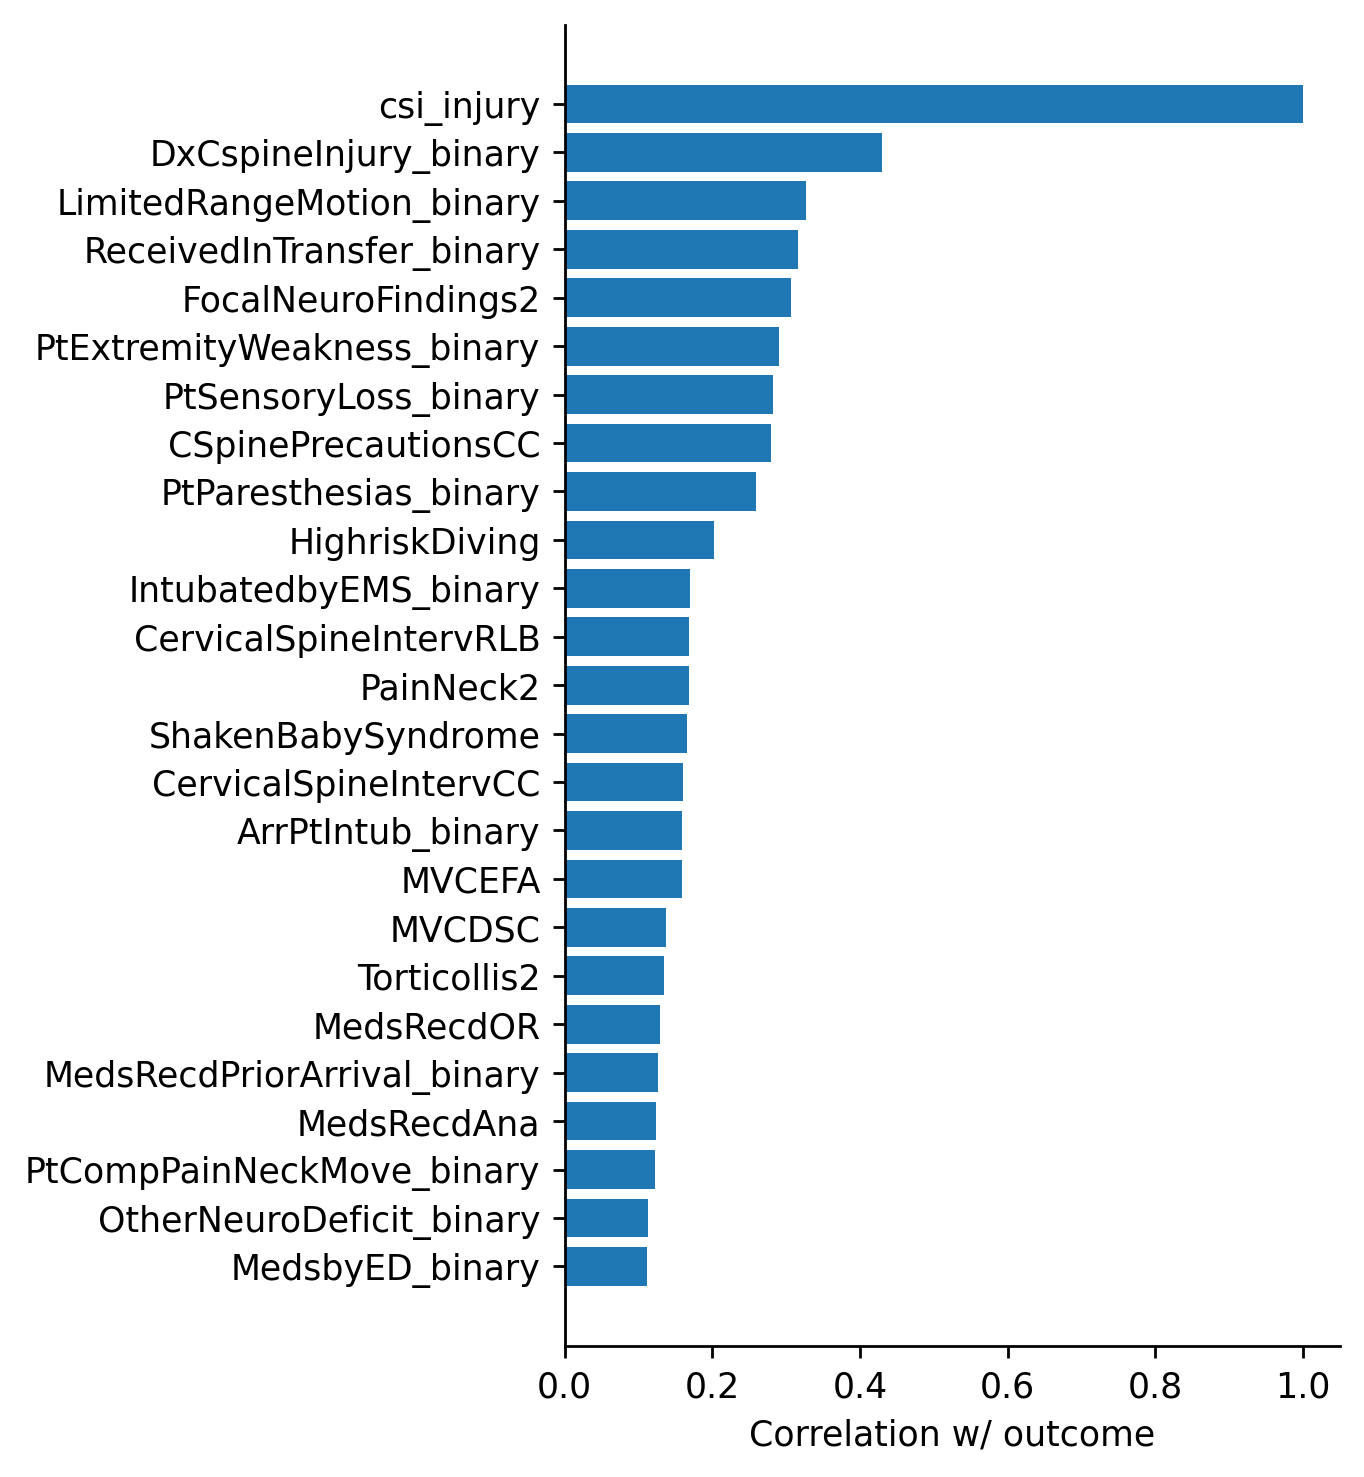

In [11]:
plt.figure(dpi=250, figsize=(4, 7))
vals = binary_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[-25:], vals[args][-25:])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

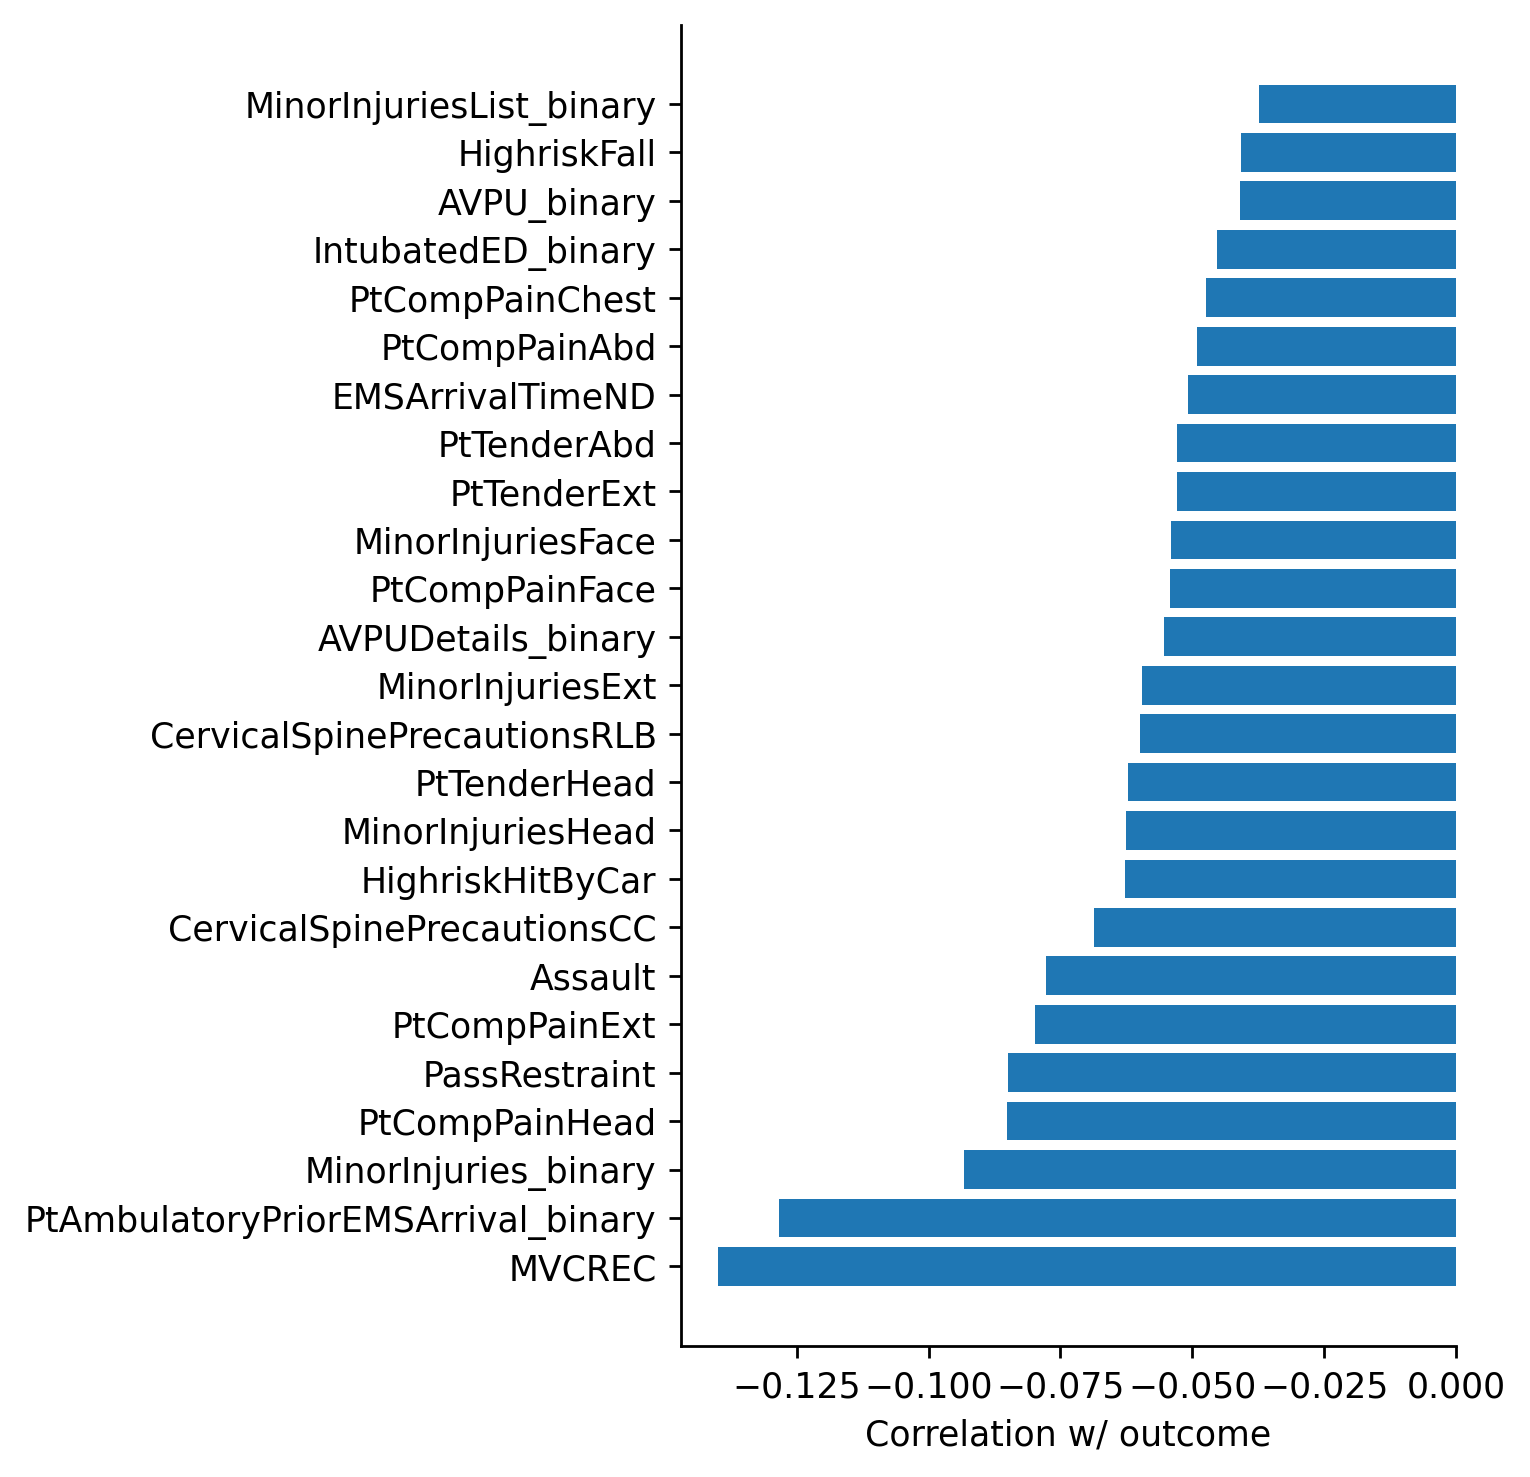

In [12]:
plt.figure(dpi=250, figsize=(4, 7))
vals = binary_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:25], vals[args][:25])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

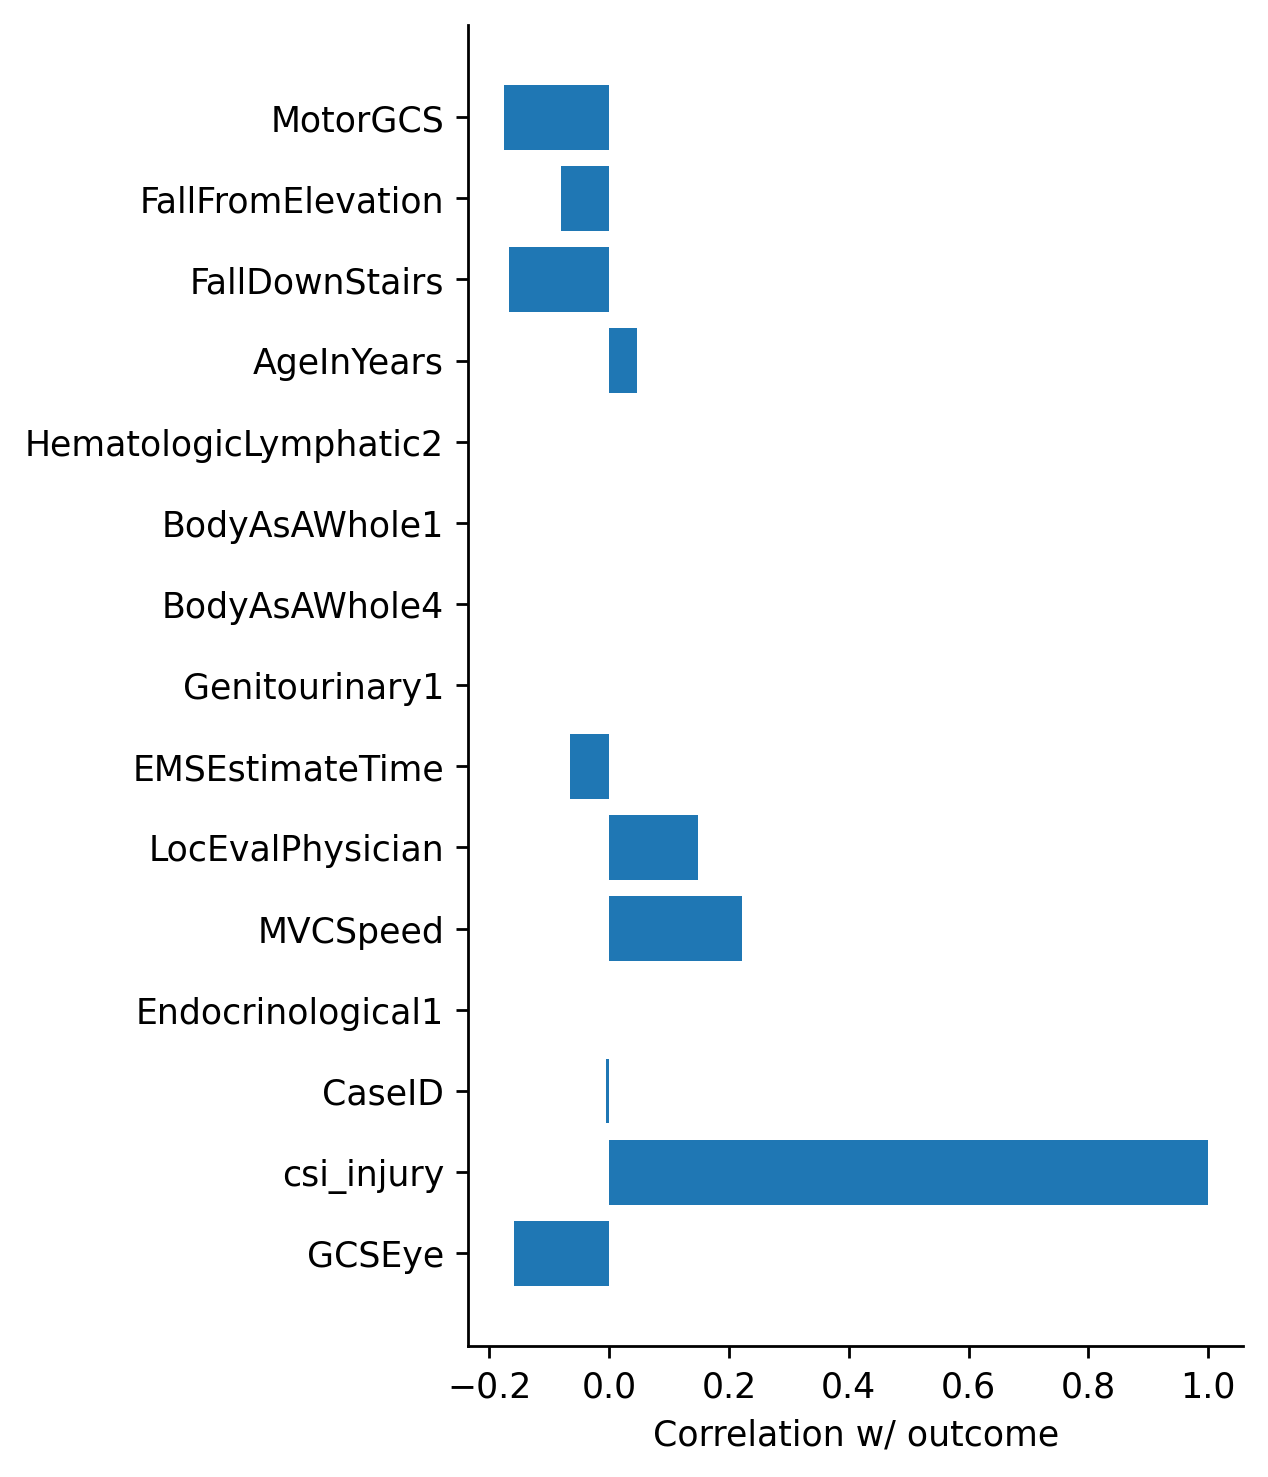

In [13]:
plt.figure(dpi=250, figsize=(4, 7))
vals = cont_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs, vals[args])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

# EDA of Missingness

In [14]:
# get percent missing by column
missing_frac = (eda_df.isna().sum() / eda_df.shape[0]) * 100
print(missing_frac.sort_values(ascending=False)[:25])

bin_missing_frac = (binary_eda_data.isna().sum() / binary_eda_data.shape[0]) * 100
print(bin_missing_frac.sort_values(ascending=False)[:25])

OMTSpeed                              98.913699
FallDownStairs                        97.284249
ChildAbuse                            93.723597
Assault                               93.723597
ShakenBabySyndrome                    93.723597
PtCompPainNeckMove_binary             93.361497
EMSEstimateTime                       88.563669
MVCSpeed                              88.050694
FallFromElevation                     86.481593
IntubatedED_binary                    83.011467
MedsbyED_binary                       82.377791
helmet_binary                         78.424864
LimitedRangeMotion_binary             74.864212
PassRestraint                         74.652987
MVCEFA                                73.174412
MVCHOC                                73.174412
MVCRO                                 73.174412
MVCSI                                 73.174412
MVCREC                                73.174412
MVCDSC                                73.174412
PtAmbulatoryPriorEMSArrival_binary    71

In [15]:
complete_binary_covar = binary_columns[bin_missing_frac==0]
print(len(complete_binary_covar))

missing_columns = binary_columns[bin_missing_frac!=0]
print(len(missing_columns))

100
60


In [16]:
binary_missing_bools = binary_eda_data[missing_columns].isna()
binary_missing_corrs = binary_missing_bools.corr(method='spearman')

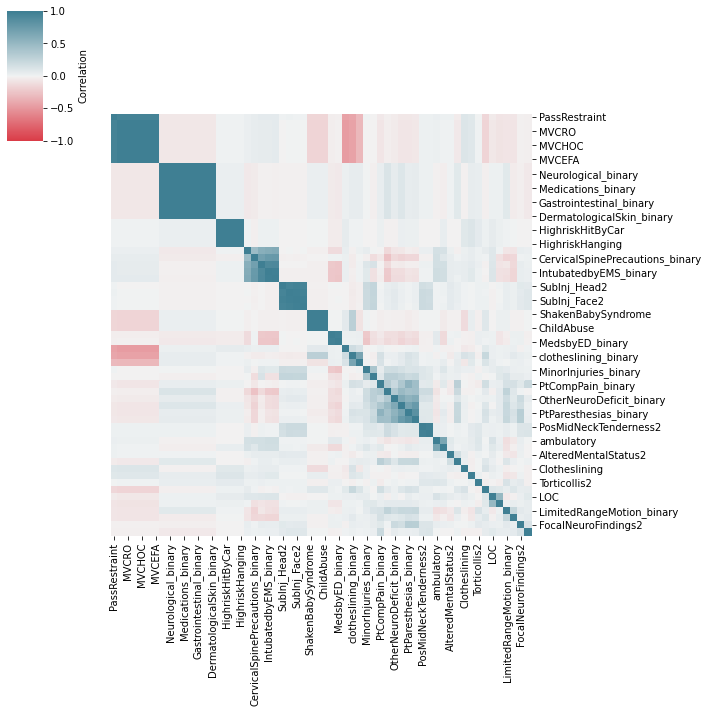

In [17]:
corrmap = sns.clustermap(binary_missing_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)

# EDA of Demographic Data

In [18]:
eda_demographic_df = pd.read_csv("data/csi_pecarn/raw/demographics.csv").set_index(["studysubjectid"])
print(eda_demographic_df.columns)

Index(['site', 'caseid', 'controltype', 'AgeInYears', 'Gender', 'Race',
       'Ethnicity', 'PayorType', 'PayorTypeCI', 'PayorTypeMA'],
      dtype='object')


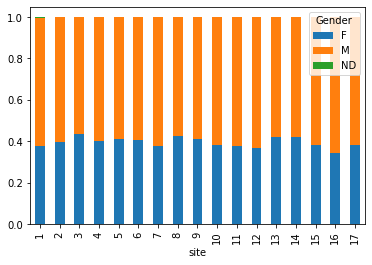

In [19]:
gender_df = eda_demographic_df.groupby('site')['Gender'].value_counts(normalize=True)
gender_df.unstack().plot(kind='bar', stacked=True)

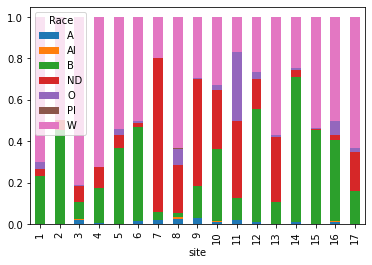

In [20]:
race_df = eda_demographic_df.groupby('site')['Race'].value_counts(normalize=True)
race_df.unstack().plot(kind='bar', stacked=True)

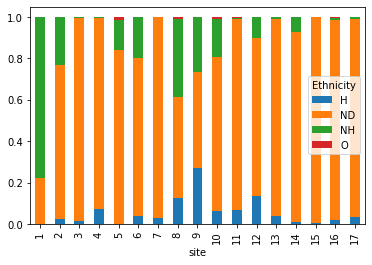

In [21]:
ethnicity_df = eda_demographic_df.groupby('site')['Ethnicity'].value_counts(normalize=True)
ethnicity_df.unstack().plot(kind='bar', stacked=True)

site  PayorType
1     CI           0.594595
      MA           0.277027
      ND           0.108108
      SU           0.013514
      OG           0.006757
Name: PayorType, dtype: float64


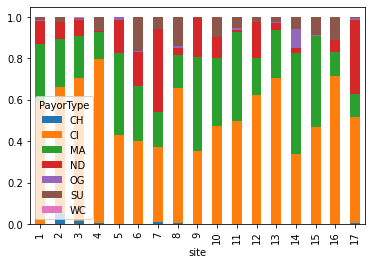

In [22]:
payor_df = eda_demographic_df.groupby('site')['PayorType'].value_counts(normalize=True)
print(payor_df.head())
payor_df.unstack().plot(kind='bar', stacked=True)

<ipython-input-23-d97eedaba98b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_df['AgeBin'] = pd.cut(age_df['AgeInYears'], bins, labels=names)


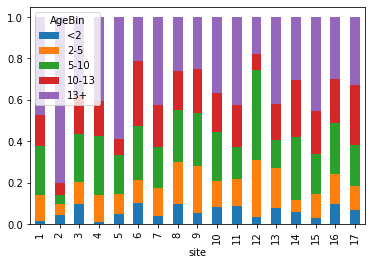

In [23]:
age_df = eda_demographic_df[['site','AgeInYears']]


bins = [0, 2, 5, 10, 13, np.inf]
names = ['<2', '2-5', '5-10', '10-13', '13+']

age_df['AgeBin'] = pd.cut(age_df['AgeInYears'], bins, labels=names)

age_range_df = age_df.groupby('site')['AgeBin'].value_counts(normalize=True)
#print(age_range_df)
age_range_df.unstack().plot(kind='bar', stacked=True)

Function below

In [24]:
def numeric_to_binary(input_df):
    '''
    This function properly encodes variables are recorded as numeric but can be encoded as binary. 
    '''
    numeric_data = input_df.select_dtypes([np.number]) # separate data that is already numeric
    char_data = input_df.select_dtypes([np.object]) # gets columns encoded as strings
    binary_data = pd.DataFrame(index=input_df.index) # study subject ID
    
    for column in char_data:
        char_column = char_data[column] # select column
        unique_values = pd.unique(char_column) # get unique entries
        
        # encode yes as 1, no as 0
        if (('Y' in unique_values)|('A' in unique_values)) & ('N' in unique_values):
            conditions  = [char_column == 'Y',char_column == 'A',char_column == 'N']
            encodings = [1,1,0]
            binary_encoded = np.select(conditions, encodings, default=np.nan)
            col_name = column+"_binary"
            binary_data[col_name] = binary_encoded
         
    result_df = pd.merge(numeric_data,binary_data,left_on=numeric_data.index,right_on=binary_data.index)
    return result_df

In [25]:
numeric_to_binary(medical_history_df)

NameError: name 'medical_history_df' is not defined